In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# creating engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflecting an existing database into a new model
Base = automap_base()

# reflecting the tables
Base.prepare(autoload_with=engine)

In [6]:
# listing all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Saving references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Creating our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Displaying the row's columns and data in dictionary format to preview data
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x135c29ebf40>,
 'prcp': 0.08,
 'id': 1,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0}

In [28]:
# Looking for the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
most_recent


'2017-08-23'

In [11]:
# Importing the datedelta package
import datedelta as dd

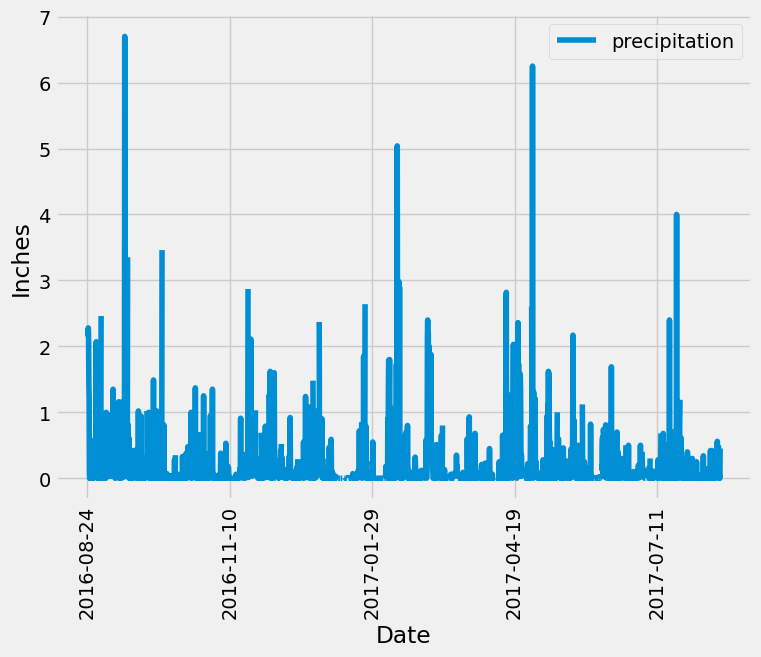

In [34]:
# Designing a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculating the date one year from the last date in data set.
query_date_limit = dt.datetime.strptime(most_recent, '%Y-%m-%d') - dd.YEAR

# Performing a query to retrieve the data and precipitation scores
one_yr_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date_limit).all()

# Saving the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(one_yr_data, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sorting the dataframe has already been sorted by date in the code above
sorted_df = df.sort_values(by='date')

# Using Pandas Plotting with Matplotlib to plot the data
sorted_df.plot(xlabel = 'Date', ylabel = 'Inches', rot=90, figsize=(8,6))
plt.tight_layout
plt.show()



In [ ]:
# Using Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [ ]:
# Getting a list of Station class column names and types
inspector = inspect(engine)
station_columns = inspector.get_columns('station')
for c in station_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [ ]:
# Getting a list of Measurement class column names and types
measurement_columns = inspector.get_columns('measurement')
for c in measurement_columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [ ]:
# Designing a query to calculate the total number stations in the dataset
session.query(func.count(Station.station)).all()


[(9,)]

In [ ]:
# importing the desc package to use it in the following cell
from sqlalchemy import desc

In [ ]:
# Designing a query to find the most active stations (i.e. what stations have the most rows?)
# by listing the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.id).label("total")).\
    group_by(Measurement.station).order_by(desc("total")).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# Getting the station id that has the greatest number of observations 
# and storing it into a variable along with its count. The variable will used in the following cell
greatest_station = session.query(Measurement.station, func.count(Measurement.id).label("total")).\
    group_by(Measurement.station).order_by(desc("total")).first()
greatest_station

('USC00519281', 2772)

In [ ]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
greatest_station_temps = session.query(*sel).filter(Measurement.station == greatest_station[0]).\
    group_by(Measurement.station).all()

print(f"The station with the most observation is {greatest_station[0]}, with lowest, highest and average temperature as follow {greatest_station_temps[0]} respectively")

The station with the most observation is USC00519281, with lowest, highest and average temperature as follow (54.0, 85.0, 71.66378066378067) respectively


In [ ]:
# Using the most active station id
# to query the last 12 months of temperature observation data for this station 
most_active_station_recent_yr = session.query(Measurement.tobs).\
    filter(Measurement.station == greatest_station[0]).\
        filter(Measurement.date >= query_date_limit).all()
df1 = pd.DataFrame(most_active_station_recent_yr, columns=['tobs'])


,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


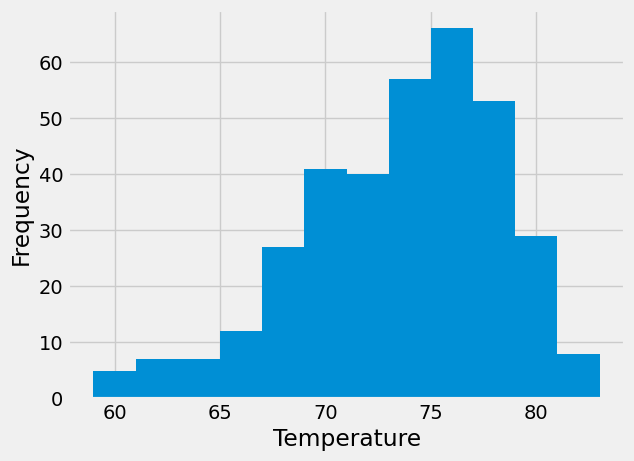

In [ ]:
# Plotting the above results as a histogram with bins=12
plt.hist(df1, bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close session

In [ ]:
# Closing Session
session.close()